In [1]:
import math
import warnings
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
import torch.utils.data as data_utils
import matplotlib.pyplot as plt

from utils.losses import TiltedLC
from utils.loops import trainCLRregression, trainLRregression, trainLBFGS
from utils.networks import regressionNetwork

In [2]:
dataClass= UCIDatasets("power", data_path="", n_splits=10) # has a field named 'data' that contains the data

trainData= dataClass.get_split(train=True)
trainLoader= torch.utils.data.DataLoader(trainData, batch_size=64, shuffle= True) # creating a loader with full batch size to ensure LBFGS works
trainLoaderLBFGS= torch.utils.data.DataLoader(trainData, batch_size= dataClass.data.shape[0], shuffle= True) # creating a loader with full batch size to ensure LBFGS works
testData= dataClass.get_split(train= False)
testLoader= torch.utils.data.DataLoader(testData, batch_size= 64, shuffle= True)
testLoaderLBFGS= torch.utils.data.DataLoader(testData, batch_size= dataClass.data.shape[0], shuffle= True)

NameError: name 'UCIDatasets' is not defined

In [2]:
dataset = './Datasets/Regression/RedShift.csv'
x_cols = list(range(26))
y_col = 27
separator = ","
remove_head = True


# attribute_index =   # This controls which attribute is allowed to vary, 7,5
# attribute_name = "BMI" # Name of the attribute, used in the plots, max heart rate
# latent_name = "Diabetes" # Name of the function, used in the plots
# # The other attributes are replaced by the median value of the attribute
Scaler= StandardScaler()
batch_is= 512

total_epochs = 20

### 
def create_xy(dataset, attribute_columns, target_column, delim, split_ratio, ditch_head=True):
    with open(dataset, 'r') as f:
        lines = f.readlines()
    if ditch_head:
        lines = lines[1:]
    X = []
    Y = []
    for line in lines:
        while len(line) > 0 and line[-1] == "\n":
            line = line[:len(line)-1]
        split_array = line.split(delim)
        all_columns = []
        for value in split_array:
            if value !="" and value !=" ":
                all_columns.append(value)
        if len(all_columns)==0:
            break
        point = []
        for i in attribute_columns:
            point.append(float(all_columns[i]))
        X.append(point)
        Y.append(float(all_columns[target_column]))
    X_arr = np.asarray(X)
    X_unscaled = np.asarray(X)
    Scaler.fit(X_arr)
    X_arr = Scaler.transform(X_arr)
    Y_arr = np.asarray(Y)
    thresh = 0
    # Y_arr_binary = np.where(Y_arr<=thresh,0,1)
    # unique, counts = np.unique(Y_arr_binary, return_counts=True)
    x_train, x_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = split_ratio)
    return x_train, x_test, y_train, y_test, Y_arr, X_arr, X_unscaled, X_arr.shape[0]

###
X_train,X_val,y_train,y_val, data_Y, data_X_scaled, data_X_unscaled, full= create_xy(dataset, x_cols, y_col, separator, 0.4, ditch_head= remove_head)
shap_x_train = X_train.copy()
shap_x_val = X_val.copy()
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
# y_train= F.one_hot(y_train.to(torch.int64), num_classes=2)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
# y_val= F.one_hot(y_val.to(torch.int64), num_classes=2)
train_dataset = data_utils.TensorDataset(X_train, y_train)
test_dataset = data_utils.TensorDataset(X_val, y_val)
trainLoader= data_utils.DataLoader(train_dataset, batch_size= batch_is, pin_memory=True,shuffle=True,num_workers = 1)
trainLoaderLBFGS= data_utils.DataLoader(train_dataset, batch_size= int(full/50), pin_memory=True,shuffle=True,num_workers = 1)
testLoader= data_utils.DataLoader(test_dataset,batch_size= batch_is,pin_memory=True,shuffle = False,num_workers = 1)


In [3]:
data_batch, labels_batch = next(iter(trainLoader))

try:
    inDim, outDim= data_batch.shape[1], labels_batch.shape[1]
except IndexError:
    inDim, outDim= data_batch.shape[1], 1


In [4]:
# global initialisations:
h= 0.4 # smoothing parameter for the log-cosh 
tau= 0.5
device= ('cuda' if torch.cuda.is_available() else 'cpu')
criterion1= TiltedLC()
criterion2= nn.MSELoss()
criterion3= nn.L1Loss()
N_EPOCHS= 100

In [5]:
size1, size2= 300, 300
model_LBFGS_LC= regressionNetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_LBFGS_LC= optim.LBFGS(model_LBFGS_LC.parameters())
lossList_LBFGS_LC= []
valList_LBFGS_LC= []

model_LBFGS_MSE= regressionNetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_LBFGS_MSE= optim.LBFGS(model_LBFGS_MSE.parameters())
lossList_LBFGS_MSE= []
valList_LBFGS_MSE= []

model_CLR_L1= regressionNetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_CLR_L1= optim.Adam(model_CLR_L1.parameters(), lr= 0.1)
lossList_CLR_L1= []
valList_CLR_L1= []

model_CLR_LC= regressionNetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_CLR_LC= optim.Adam(model_CLR_LC.parameters(), lr= 0.1)
lossList_CLR_LC= []
valList_CLR_LC= []

model_CLR_MSE= regressionNetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_CLR_MSE= optim.Adam(model_CLR_MSE.parameters(), lr= 0.1)
lossList_CLR_MSE= []
valList_CLR_MSE= []

model_LALR_L1= regressionNetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_LALR_L1= optim.Adam(model_LALR_L1.parameters(), lr= 0.1)
lossList_LALR_L1= []
valList_LALR_L1= []

model_LALR_LC= regressionNetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_LALR_LC= optim.Adam(model_LALR_LC.parameters(), lr= 0.1)
lossList_LALR_LC= []
valList_LALR_LC= []

model_LALR_MSE= regressionNetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_LALR_MSE= optim.Adam(model_LALR_MSE.parameters(), lr= 0.1)
lossList_LALR_MSE= []
valList_LALR_MSE= []

In [ ]:
# LBFGS, LC
trainLBFGS(model_LBFGS_LC, optimizer_LBFGS_LC, trainLoaderLBFGS, testLoader, criterion1, tau,  N_EPOCHS, lossList_LBFGS_LC, valList_LBFGS_LC, "LC")

In [ ]:
# LBFGS, MSE
trainLBFGS(model_LBFGS_MSE, optimizer_LBFGS_MSE, trainLoaderLBFGS, testLoader, criterion2, tau,  N_EPOCHS, lossList_LBFGS_MSE, valList_LBFGS_MSE, "MSE")

In [ ]:
trainCLRregression(model_CLR_L1, optimizer_CLR_L1, trainLoader, testLoader, criterion3, tau,  N_EPOCHS, lossList_CLR_L1, valList_CLR_L1, "L1")

In [10]:
# CLR, MAE:
trainCLRregression(model_CLR_L1, optimizer_CLR_L1, trainLoader, testLoader, criterion3, tau,  N_EPOCHS, lossList_CLR_L1, valList_CLR_L1, "L1")

/home/aryamanj/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/aryamanj/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


/home/aryamanj/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([465])) that is different to the input size (torch.Size([465, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


/home/aryamanj/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Training loss: 1.8475094551091806 Validation loss: 1.600039136082123


/home/aryamanj/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([310])) that is different to the input size (torch.Size([310, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 Training loss: 2.375837668797529 Validation loss: 1.7442589511831013


Epoch: 2 Training loss: 1.4512604332104724 Validation loss: 2.0683408940317265


Epoch: 3 Training loss: 1.6940049962869652 Validation loss: 2.2430047893120926


Epoch: 4 Training loss: 1.5839553963818571 Validation loss: 2.0612476423981327


Epoch: 5 Training loss: 1.505375693816224 Validation loss: 1.6072419266872124


Epoch: 6 Training loss: 1.545251032949671 Validation loss: 1.4626573225912534


Epoch: 7 Training loss: 1.6118729266696656 Validation loss: 1.6813657036795424


Epoch: 8 Training loss: 1.7345694348909624 Validation loss: 2.0314333718624478


Epoch: 9 Training loss: 1.5750723044862196 Validation loss: 1.7844435173159674


Epoch: 10 Training loss: 1.7958591677069833 Validation loss: 2.5984709661052294


Epoch: 11 Training loss: 1.5814656375661724 Validation loss: 1.470461145767954


Epoch: 12 Training loss: 1.5294724752435562 Validation loss: 2.179520759723655


Epoch: 13 Training loss: 1.6975007401871245 Validation loss: 1.5574560172966117


Epoch: 14 Training loss: 1.6269718364028232 Validation loss: 2.2373870795171307


Epoch: 15 Training loss: 1.6436923834769783 Validation loss: 2.79446907527351


Epoch: 16 Training loss: 1.5417884737043017 Validation loss: 2.3254651141217093


Epoch: 17 Training loss: 1.6466211401693238 Validation loss: 1.8214441424444412


Epoch: 18 Training loss: 1.5604796771101959 Validation loss: 1.4522481168803403


Epoch: 19 Training loss: 1.543606374008195 Validation loss: 2.839257766026019


Epoch: 20 Training loss: 1.5967008247025762 Validation loss: 1.9319552949316658


Epoch: 21 Training loss: 1.553934597077928 Validation loss: 1.7013749032897627


Epoch: 22 Training loss: 1.5631388702412754 Validation loss: 2.1664182408919546


Epoch: 23 Training loss: 1.7154536971084153 Validation loss: 1.7305549284872495


Epoch: 24 Training loss: 1.6668744890074467 Validation loss: 1.7399984555315013


Epoch: 25 Training loss: 1.5552906890009623 Validation loss: 1.8379076371485286


Epoch: 26 Training loss: 1.5890741058229896 Validation loss: 1.7919852277441206


Epoch: 27 Training loss: 1.4461099829929336 Validation loss: 1.5330044144555832


Epoch: 28 Training loss: 1.5626098041978307 Validation loss: 1.5158014662926091


Epoch: 29 Training loss: 1.770202789051072 Validation loss: 1.7051286936814387


Epoch: 30 Training loss: 1.5250511076958122 Validation loss: 2.40222270040129


Epoch: 31 Training loss: 1.5047288300792656 Validation loss: 1.8360818866443431


Epoch: 32 Training loss: 1.5177200804812616 Validation loss: 1.9178745209792705


Epoch: 33 Training loss: 1.602342014420352 Validation loss: 2.2149613510982684


Epoch: 34 Training loss: 1.6315980451903995 Validation loss: 2.626054527895647


Epoch: 35 Training loss: 1.5784802140066418 Validation loss: 1.6155939707040283


Epoch: 36 Training loss: 1.750990696282918 Validation loss: 1.6847606315169223


Epoch: 37 Training loss: 1.5330045473760543 Validation loss: 2.508602848012654


Epoch: 38 Training loss: 1.5636714549764088 Validation loss: 1.6933909354703875


Epoch: 39 Training loss: 1.5341850982398342 Validation loss: 2.06304355882439


Epoch: 40 Training loss: 1.5583535931342412 Validation loss: 1.9604332953628476


Epoch: 41 Training loss: 1.6126734769899183 Validation loss: 2.1021543511880627


Epoch: 42 Training loss: 1.5988669364341392 Validation loss: 2.1017220252160036


Epoch: 43 Training loss: 1.5431885145110706 Validation loss: 2.6217470910029985


Epoch: 44 Training loss: 1.5771555936723234 Validation loss: 2.8072114278095723


Epoch: 45 Training loss: 1.5647288141364943 Validation loss: 2.4094491851758253


Epoch: 46 Training loss: 1.5615734035945241 Validation loss: 1.558518787015064


Epoch: 47 Training loss: 1.49681014461477 Validation loss: 1.8273949504654705


Epoch: 48 Training loss: 1.5108130749929776 Validation loss: 3.560110481294467


Epoch: 49 Training loss: 1.5946554182614863 Validation loss: 1.8939921440080154


Epoch: 50 Training loss: 1.5647943192207594 Validation loss: 2.5403968693086005


Epoch: 51 Training loss: 1.6243087577887079 Validation loss: 2.5587802069383745


Epoch: 52 Training loss: 1.5704051644576789 Validation loss: 1.9101572502995143


Epoch: 53 Training loss: 1.5207497511999564 Validation loss: 1.8327976404738477


Epoch: 54 Training loss: 1.6450150005403796 Validation loss: 2.9281192561788743


Epoch: 55 Training loss: 1.5790076921621734 Validation loss: 1.8007413794071931


Epoch: 56 Training loss: 1.5857103880605172 Validation loss: 1.5100872836707762


Epoch: 57 Training loss: 1.6152103165813494 Validation loss: 2.106093411969836


Epoch: 58 Training loss: 1.5477603137577203 Validation loss: 1.9081336038057195


Epoch: 59 Training loss: 1.5805580032561157 Validation loss: 2.60438432249912


Epoch: 60 Training loss: 1.4835507815916549 Validation loss: 2.1571265292722126


Epoch: 61 Training loss: 1.6256722704479825 Validation loss: 1.519977666358867


Epoch: 62 Training loss: 1.5595530459003153 Validation loss: 2.032305975293004


Epoch: 63 Training loss: 1.573687027304398 Validation loss: 1.471255885622214


Epoch: 64 Training loss: 1.5772806361464755 Validation loss: 2.254520022087823


Epoch: 65 Training loss: 1.5087653678462267 Validation loss: 1.4713848219361416


Epoch: 66 Training loss: 1.5596801344363074 Validation loss: 1.6644629940674118


Epoch: 67 Training loss: 1.5344828394975918 Validation loss: 1.8119047812125144


Epoch: 68 Training loss: 1.551097474078029 Validation loss: 2.180387685717286


Epoch: 69 Training loss: 1.4935473961117238 Validation loss: 2.230298157222175


Epoch: 70 Training loss: 1.6254640669681457 Validation loss: 1.876517294577262


Epoch: 71 Training loss: 1.5826629361581734 Validation loss: 2.1939007313508565


Epoch: 72 Training loss: 1.4656961002874442 Validation loss: 2.097727834296277


Epoch: 73 Training loss: 1.5516546623326828 Validation loss: 2.5360658753497907


Epoch: 74 Training loss: 1.4617628334943935 Validation loss: 1.5217526389982938


Epoch: 75 Training loss: 1.6280407110289559 Validation loss: 2.0039579689376703


Epoch: 76 Training loss: 1.5282138953424138 Validation loss: 1.768664476231339


Epoch: 77 Training loss: 1.662310351437675 Validation loss: 2.1237601881047383


Epoch: 78 Training loss: 1.573510485912748 Validation loss: 1.7187473511847078


Epoch: 79 Training loss: 1.6192185872868858 Validation loss: 2.1430367087713003


Epoch: 80 Training loss: 1.6184260217191806 Validation loss: 1.7580887643781826


Epoch: 81 Training loss: 1.5029279188645743 Validation loss: 2.01431125944311


Epoch: 82 Training loss: 1.6105233044987506 Validation loss: 1.911318108092907


Epoch: 83 Training loss: 1.649291244481279 Validation loss: 1.7715082274430902


Epoch: 84 Training loss: 1.5200176330648458 Validation loss: 1.5867678093355755


Epoch: 85 Training loss: 1.6114930439062616 Validation loss: 1.9592132638927242


Epoch: 86 Training loss: 1.5138048211845592 Validation loss: 1.6938305271604348


Epoch: 87 Training loss: 1.6064989558396117 Validation loss: 2.0809635123037133


Epoch: 88 Training loss: 1.628193015356158 Validation loss: 1.6219976611167632


Epoch: 89 Training loss: 1.5365331367982291 Validation loss: 1.9029102015444894


Epoch: 90 Training loss: 1.4746181470550839 Validation loss: 2.3677116876928803


Epoch: 91 Training loss: 1.552089585319729 Validation loss: 2.245331695165493


Epoch: 92 Training loss: 1.5689702650219497 Validation loss: 1.8070632095820809


Epoch: 93 Training loss: 1.5221690904606549 Validation loss: 1.9773560923703377


Epoch: 94 Training loss: 1.5336399903922895 Validation loss: 2.456121689673458


Epoch: 95 Training loss: 1.6198977701922903 Validation loss: 1.6506171939740977


Epoch: 96 Training loss: 1.5745436243176965 Validation loss: 1.6931691399084337


Epoch: 97 Training loss: 1.548913774352484 Validation loss: 1.858298285062923


Epoch: 98 Training loss: 1.5903585975193675 Validation loss: 2.665189572670999


Epoch: 99 Training loss: 1.543424868785444 Validation loss: 1.9606534550104282


In [11]:
# CLR, MSE
trainCLRregression(model_CLR_MSE, optimizer_CLR_MSE, trainLoader, testLoader,  criterion2, tau,  N_EPOCHS, lossList_CLR_MSE, valList_CLR_MSE, "MSE")

/home/aryamanj/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([465])) that is different to the input size (torch.Size([465, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Training loss: 3.026522943936551 Validation loss: 1.9318242899711238


Epoch: 1 Training loss: 2.320650103902615 Validation loss: 1.5142982631102677


Epoch: 2 Training loss: 2.8421826313850067 Validation loss: 1.4558877718121002


Epoch: 3 Training loss: 2.366010712635702 Validation loss: 1.4864826953436305


Epoch: 4 Training loss: 2.32166416369305 Validation loss: 1.4940478796686734


Epoch: 5 Training loss: 3.536183454085809 Validation loss: 1.5035000936173486


Epoch: 6 Training loss: 2.315348964988429 Validation loss: 1.4385064111955574


Epoch: 7 Training loss: 2.237009763381377 Validation loss: 1.4568763936044802


Epoch: 8 Training loss: 2.4294198146155592 Validation loss: 1.4993340694375068


Epoch: 9 Training loss: 2.387128782877633 Validation loss: 1.4830257423836384


Epoch: 10 Training loss: 3.5062935298521527 Validation loss: 1.5218293868462076


Epoch: 11 Training loss: 2.2828285685715453 Validation loss: 1.4885715094983705


Epoch: 12 Training loss: 2.3609148643921394 Validation loss: 1.6689556698466457


Epoch: 13 Training loss: 2.8705555375439493 Validation loss: 1.4733349319240256


Epoch: 14 Training loss: 2.291408534783066 Validation loss: 1.454514843968962


Epoch: 15 Training loss: 2.4442921974426937 Validation loss: 1.4385285556442389


Epoch: 16 Training loss: 3.640497828740495 Validation loss: 4.086474224578502


Epoch: 17 Training loss: 2.453167928963353 Validation loss: 1.4867228279658151


Epoch: 18 Training loss: 2.314365079103639 Validation loss: 1.4816123489093578


Epoch: 19 Training loss: 2.396770777251724 Validation loss: 1.6010873705841775


Epoch: 20 Training loss: 2.4209958523385784 Validation loss: 1.4800219898748095


Epoch: 21 Training loss: 2.4856084139626184 Validation loss: 1.9069230581690846


Epoch: 22 Training loss: 2.47106485844331 Validation loss: 1.437930276731608


Epoch: 23 Training loss: 2.43166219212945 Validation loss: 1.5825769767700744


Epoch: 24 Training loss: 2.5104709799770575 Validation loss: 1.5244066619469803


Epoch: 25 Training loss: 2.8587900242112756 Validation loss: 1.504186045795868


Epoch: 26 Training loss: 2.2418647024291865 Validation loss: 1.4503307592037111


Epoch: 27 Training loss: 2.565632253170686 Validation loss: 1.7079621213183092


Epoch: 28 Training loss: 2.3842921388166074 Validation loss: 1.5823436678085971


Epoch: 29 Training loss: 2.4708788028388837 Validation loss: 1.457653731422747


Epoch: 30 Training loss: 2.418194370982677 Validation loss: 1.549019016372729


Epoch: 31 Training loss: 2.4125515343608237 Validation loss: 1.6027627311347654


Epoch: 32 Training loss: 2.513773501339685 Validation loss: 1.4447007721120662


Epoch: 33 Training loss: 2.4350889457129625 Validation loss: 1.5917912358713453


Epoch: 34 Training loss: 2.491800823736258 Validation loss: 1.4419473429814957


Epoch: 35 Training loss: 2.5037120417580114 Validation loss: 1.651723011351539


Epoch: 36 Training loss: 2.4612158283023806 Validation loss: 1.5257061921516886


Epoch: 37 Training loss: 2.4258193065148315 Validation loss: 1.4489483664454164


Epoch: 38 Training loss: 2.5362325767199647 Validation loss: 1.4567664909564415


Epoch: 39 Training loss: 2.3972361106294167 Validation loss: 1.7131380598842467


Epoch: 40 Training loss: 2.5224304609473567 Validation loss: 1.6272024929397455


Epoch: 41 Training loss: 2.421327468370349 Validation loss: 1.6355214585209499


Epoch: 42 Training loss: 2.474671921709865 Validation loss: 1.815173736082323


Epoch: 43 Training loss: 2.4699502206487614 Validation loss: 1.4551067513592904


Epoch: 44 Training loss: 2.5054988371804674 Validation loss: 1.4675921095854132


Epoch: 45 Training loss: 2.4606832474344036 Validation loss: 1.4640832169111384


Epoch: 46 Training loss: 2.420271761494732 Validation loss: 1.4611067756789935


Epoch: 47 Training loss: 2.4652307949886674 Validation loss: 1.605732795804046


Epoch: 48 Training loss: 2.5222692886427867 Validation loss: 1.4812595705653346


Epoch: 49 Training loss: 2.466573621725666 Validation loss: 1.5079657076277138


Epoch: 50 Training loss: 2.461421524688118 Validation loss: 2.302663379189328


Epoch: 51 Training loss: 2.3968324434269634 Validation loss: 1.551577081135917


Epoch: 52 Training loss: 2.5372834155186275 Validation loss: 1.7449368387145674


Epoch: 53 Training loss: 2.497784130664067 Validation loss: 1.4395412635097544


Epoch: 54 Training loss: 2.446415072940132 Validation loss: 1.6737017195522155


Epoch: 55 Training loss: 2.4409470617014533 Validation loss: 1.7317082209012473


Epoch: 56 Training loss: 2.69247316523903 Validation loss: 1.5020768735675933


Epoch: 57 Training loss: 2.3135248679872626 Validation loss: 1.6794270234178539


Epoch: 58 Training loss: 2.4951645462065724 Validation loss: 1.7847082062957151


Epoch: 59 Training loss: 2.4592156691006446 Validation loss: 1.5827695660560883


Epoch: 60 Training loss: 2.4172974705527968 Validation loss: 1.5368915665225298


Epoch: 61 Training loss: 2.490052941824048 Validation loss: 1.4668344569256644


Epoch: 62 Training loss: 2.4804090670032797 Validation loss: 1.4801175455714382


Epoch: 63 Training loss: 2.3867640080001356 Validation loss: 1.5075046938015089


Epoch: 64 Training loss: 2.464009447057425 Validation loss: 1.4401139948383195


Epoch: 65 Training loss: 2.530030024236617 Validation loss: 1.6739702764071571


Epoch: 66 Training loss: 2.4384660661977167 Validation loss: 1.461392534207592


Epoch: 67 Training loss: 2.456663232764337 Validation loss: 1.4788910205974135


Epoch: 68 Training loss: 2.397655332542441 Validation loss: 1.489636635175467


Epoch: 69 Training loss: 2.472403503271353 Validation loss: 1.4601960141865447


Epoch: 70 Training loss: 2.511320644944948 Validation loss: 1.5923919594565104


Epoch: 71 Training loss: 2.502071541690692 Validation loss: 1.7211108563062252


Epoch: 72 Training loss: 2.447673953975037 Validation loss: 1.4834655165420274


Epoch: 73 Training loss: 2.4334882069037564 Validation loss: 1.5890542014204674


Epoch: 74 Training loss: 2.4791850276995446 Validation loss: 1.5158029950950414


Epoch: 75 Training loss: 2.4380507897927157 Validation loss: 1.5145486764625566


Epoch: 76 Training loss: 2.540260812795717 Validation loss: 1.4504920778516484


Epoch: 77 Training loss: 2.4272609488415955 Validation loss: 2.1972104923417652


Epoch: 78 Training loss: 2.4087941407821076 Validation loss: 1.5400767762363587


Epoch: 79 Training loss: 2.465543391001746 Validation loss: 1.5887453278829886


Epoch: 80 Training loss: 2.505007892805027 Validation loss: 1.5425853406652084


Epoch: 81 Training loss: 2.439116587087365 Validation loss: 1.4890336677841607


Epoch: 82 Training loss: 2.453204373714786 Validation loss: 1.6472232336725796


Epoch: 83 Training loss: 2.4611467975487327 Validation loss: 1.4542483159401955


Epoch: 84 Training loss: 2.42049101495272 Validation loss: 1.7612024283560335


Epoch: 85 Training loss: 2.4807919457197527 Validation loss: 1.6141277332386557


Epoch: 86 Training loss: 2.4722652966616354 Validation loss: 1.4891048647132534


Epoch: 87 Training loss: 2.4769775635432794 Validation loss: 1.4871110598582293


Epoch: 88 Training loss: 2.472039700226992 Validation loss: 1.4517600170905696


Epoch: 89 Training loss: 2.4176949943574764 Validation loss: 1.4932786642118943


Epoch: 90 Training loss: 2.5270221818485448 Validation loss: 1.5133031800735828


Epoch: 91 Training loss: 2.4153611157273374 Validation loss: 1.5634694122108799


Epoch: 92 Training loss: 2.4444538765128474 Validation loss: 1.4658827942975228


Epoch: 93 Training loss: 2.447641457926235 Validation loss: 1.6491402062502774


Epoch: 94 Training loss: 2.428542710662056 Validation loss: 1.9068924337310469


Epoch: 95 Training loss: 2.4547636952823915 Validation loss: 1.4571824479556739


Epoch: 96 Training loss: 2.486996919715354 Validation loss: 1.4425692790154423


Epoch: 97 Training loss: 2.558361710715193 Validation loss: 1.4889863099406688


Epoch: 98 Training loss: 2.392702782776191 Validation loss: 1.6836807551394053


Epoch: 99 Training loss: 2.4844003216335904 Validation loss: 1.5647384286178847


In [12]:
# CLR, LC
trainCLRregression(model_CLR_LC, optimizer_CLR_LC, trainLoader, testLoader,  criterion1, tau,  N_EPOCHS, lossList_CLR_LC, valList_CLR_LC, "LC")

Epoch: 0 Training loss: 0.3923737850612915 Validation loss: 1.4771632525683962


Epoch: 1 Training loss: 0.5663472604011783 Validation loss: 1.4622377384036591


Epoch: 2 Training loss: 0.34904152220075657 Validation loss: 1.4928914190094769


Epoch: 3 Training loss: 0.37437695409834637 Validation loss: 1.5587978499132282


Epoch: 4 Training loss: 0.38616320270156995 Validation loss: 1.488419685000849


Epoch: 5 Training loss: 0.34620803586182375 Validation loss: 1.4655651317842415


Epoch: 6 Training loss: 0.4356176240529933 Validation loss: 1.5259717108079294


Epoch: 7 Training loss: 0.47499351901211084 Validation loss: 1.5467594597354752


Epoch: 8 Training loss: 0.3384860615720197 Validation loss: 1.4529980421066284


Epoch: 9 Training loss: 0.5094555159465887 Validation loss: 1.4401330917632604


Epoch: 10 Training loss: 0.3356978571507423 Validation loss: 1.7218592590307837


Epoch: 11 Training loss: 0.3608740406539107 Validation loss: 1.4650448366653088


Epoch: 12 Training loss: 0.3563932103271713 Validation loss: 1.4488807704937634


Epoch: 13 Training loss: 0.36456955796992996 Validation loss: 1.8108253783957904


Epoch: 14 Training loss: 0.36522347899350865 Validation loss: 1.5070127105108022


Epoch: 15 Training loss: 0.36458708680062774 Validation loss: 1.5237266195752908


Epoch: 16 Training loss: 0.36814541736425904 Validation loss: 2.1911405226644955


Epoch: 17 Training loss: 0.36398495374344636 Validation loss: 1.638290419891067


Epoch: 18 Training loss: 0.3662238647092044 Validation loss: 1.7042178162560655


Epoch: 19 Training loss: 0.35710693137097593 Validation loss: 1.8124895131109129


Epoch: 20 Training loss: 0.3626791329789061 Validation loss: 1.611411535966724


Epoch: 21 Training loss: 0.3759810265221952 Validation loss: 1.4975942385877161


Epoch: 22 Training loss: 0.35979657608632143 Validation loss: 1.7927083722128676


Epoch: 23 Training loss: 0.35586921994709664 Validation loss: 1.4642494254082001


Epoch: 24 Training loss: 0.36978031062272776 Validation loss: 1.6111978811643088


Epoch: 25 Training loss: 0.3684666165596003 Validation loss: 1.6953057123793105


Epoch: 26 Training loss: 0.3653668701774815 Validation loss: 1.559318951774097


Epoch: 27 Training loss: 0.3600470112014052 Validation loss: 1.6001839690682247


Epoch: 28 Training loss: 0.36241462599743574 Validation loss: 1.8003336735558055


Epoch: 29 Training loss: 0.3604145512636357 Validation loss: 1.5696055070038326


Epoch: 30 Training loss: 0.37357687210330504 Validation loss: 1.6650030837250562


Epoch: 31 Training loss: 0.35671312104495523 Validation loss: 1.5146844412257252


Epoch: 32 Training loss: 0.3612092478024775 Validation loss: 1.9461674453340172


Epoch: 33 Training loss: 0.37516180149506784 Validation loss: 1.4746023366113545


Epoch: 34 Training loss: 0.35363551301747687 Validation loss: 1.7201624390438797


Epoch: 35 Training loss: 0.3632608949297406 Validation loss: 1.479761708866466


Epoch: 36 Training loss: 0.3677061552599556 Validation loss: 1.804387584549176


Epoch: 37 Training loss: 0.35933051383377634 Validation loss: 1.4586189942430492


Epoch: 38 Training loss: 0.36268622633096026 Validation loss: 2.2118074455422527


Epoch: 39 Training loss: 0.3782782659291885 Validation loss: 1.930329641126427


Epoch: 40 Training loss: 0.3630758589094213 Validation loss: 1.5734386728883545


Epoch: 41 Training loss: 0.3703578330145568 Validation loss: 1.5088627131746384


Epoch: 42 Training loss: 0.35558718821225616 Validation loss: 1.8975508225644617


Epoch: 43 Training loss: 0.35854403041986216 Validation loss: 1.4881802636019523


Epoch: 44 Training loss: 0.3671349163662395 Validation loss: 1.894165847820661


Epoch: 45 Training loss: 0.35845742928460556 Validation loss: 1.48698905960954


Epoch: 46 Training loss: 0.3591759333069133 Validation loss: 1.5255826381497857


Epoch: 47 Training loss: 0.36294084083294165 Validation loss: 1.4793828320049585


Epoch: 48 Training loss: 0.361074946621073 Validation loss: 1.5505864562242277


Epoch: 49 Training loss: 0.3561640734060527 Validation loss: 1.8242670998260788


Epoch: 50 Training loss: 0.36978783749558863 Validation loss: 1.6708635399255893


Epoch: 51 Training loss: 0.3531290114934757 Validation loss: 1.6511445925049248


Epoch: 52 Training loss: 0.36318238443144624 Validation loss: 1.5109091460326762


Epoch: 53 Training loss: 0.3630596621458554 Validation loss: 1.6001211621544578


Epoch: 54 Training loss: 0.36101567249203936 Validation loss: 1.6286468183263412


Epoch: 55 Training loss: 0.37280554710053254 Validation loss: 1.7049478509209373


Epoch: 56 Training loss: 0.3551376081572265 Validation loss: 1.5889392153657265


Epoch: 57 Training loss: 0.3619549015933603 Validation loss: 1.4605939206814917


Epoch: 58 Training loss: 0.35889338959423545 Validation loss: 1.522380630763338


Epoch: 59 Training loss: 0.3528504049450117 Validation loss: 1.5250988540891361


Epoch: 60 Training loss: 0.36205190252013536 Validation loss: 1.9263559552126153


Epoch: 61 Training loss: 0.37094645094972406 Validation loss: 1.4756669058104146


Epoch: 62 Training loss: 0.3588500791905797 Validation loss: 1.6062649334711958


Epoch: 63 Training loss: 0.36093672668648036 Validation loss: 1.6368890645388066


Epoch: 64 Training loss: 0.38466608467576197 Validation loss: 1.5568121608669612


Epoch: 65 Training loss: 0.35027991247866486 Validation loss: 1.8270310430647707


Epoch: 66 Training loss: 0.3583372447151055 Validation loss: 1.6201737156378038


Epoch: 67 Training loss: 0.36125388394710206 Validation loss: 1.5217049991353622


Epoch: 68 Training loss: 0.3788475664949888 Validation loss: 1.466299627850474


Epoch: 69 Training loss: 0.3550969851328052 Validation loss: 1.8206806301314533


Epoch: 70 Training loss: 0.3592511896774362 Validation loss: 1.509768411926689


Epoch: 71 Training loss: 0.3592205691362806 Validation loss: 1.4536145507155211


Epoch: 72 Training loss: 0.3602722711724522 Validation loss: 1.4742550741542468


Epoch: 73 Training loss: 0.36240150330769494 Validation loss: 1.5516702909550253


Epoch: 74 Training loss: 0.3695778819208253 Validation loss: 1.527313213771796


Epoch: 75 Training loss: 0.35449137115175866 Validation loss: 1.6683221992428157


Epoch: 76 Training loss: 0.35892642641437406 Validation loss: 1.4854447604737877


Epoch: 77 Training loss: 0.36312595745404114 Validation loss: 1.4493493756582572


Epoch: 78 Training loss: 0.36203439745983723 Validation loss: 1.4551002283681018


Epoch: 79 Training loss: 0.3560667077055771 Validation loss: 1.772124856521413


Epoch: 80 Training loss: 0.36690533539472076 Validation loss: 1.9837834404084445


Epoch: 81 Training loss: 0.35491138175445147 Validation loss: 1.6679584624651371


Epoch: 82 Training loss: 0.3641337249611934 Validation loss: 1.4832556487137873


Epoch: 83 Training loss: 0.3552199799057795 Validation loss: 1.532880216017838


Epoch: 84 Training loss: 0.36311884533366967 Validation loss: 1.5421783737601993


Epoch: 85 Training loss: 0.3622359536346495 Validation loss: 1.765576045558518


Epoch: 86 Training loss: 0.3635194289415276 Validation loss: 1.577757425590499


Epoch: 87 Training loss: 0.365319928640371 Validation loss: 1.9026039553999146


Epoch: 88 Training loss: 0.3557020121047796 Validation loss: 2.0433704636313696


Epoch: 89 Training loss: 0.3618475934135897 Validation loss: 1.4646203437264829


Epoch: 90 Training loss: 0.36605923394810497 Validation loss: 1.4481848183444388


Epoch: 91 Training loss: 0.3582127574931079 Validation loss: 1.7472630139385168


Epoch: 92 Training loss: 0.36133377949677 Validation loss: 1.5234840332075608


Epoch: 93 Training loss: 0.3608533635798563 Validation loss: 1.548762815951293


Epoch: 94 Training loss: 0.35812684019294544 Validation loss: 1.614902942679649


Epoch: 95 Training loss: 0.35917444289655376 Validation loss: 1.522805102027748


Epoch: 96 Training loss: 0.3614389250745894 Validation loss: 1.5722027649083046


Epoch: 97 Training loss: 0.3612087224787482 Validation loss: 1.881867813257536


Epoch: 98 Training loss: 0.3586633948790506 Validation loss: 2.0727271905157076


Epoch: 99 Training loss: 0.35812175265488405 Validation loss: 1.4467867645602397


In [13]:
# LALR, LC
trainLRregression(model_LALR_LC, optimizer_LALR_LC, trainLoader, testLoader,  criterion1, tau,  N_EPOCHS, lossList_LALR_LC, valList_LALR_LC, "LC")

/home/aryamanj/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


/home/aryamanj/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Training Loss: 2.4234987639826007 Validation loss: 1.4544850295492258 LR: 0.2633902430534363


/home/aryamanj/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([310])) that is different to the input size (torch.Size([310, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 Training Loss: 0.2874840306924664 Validation loss: 1.4853824956724557 LR: 0.04082879424095154


Epoch: 2 Training Loss: 0.28536550419034673 Validation loss: 1.4779540121429315 LR: 0.04082827270030975


Epoch: 3 Training Loss: 0.28604623986400235 Validation loss: 1.486923517686872 LR: 0.040827587246894836


Epoch: 4 Training Loss: 0.29098964849295167 Validation loss: 1.5512741617622134 LR: 0.040828436613082886


Epoch: 5 Training Loss: 0.29467686109129226 Validation loss: 1.484091310370044 LR: 0.04082872346043587


Epoch: 6 Training Loss: 0.2973265085048837 Validation loss: 1.463837007639524 LR: 0.04082896560430527


Epoch: 7 Training Loss: 0.30107501613656623 Validation loss: 1.4524117539347352 LR: 0.04083222895860672


Epoch: 8 Training Loss: 0.2979619731898032 Validation loss: 1.5356632135887227 LR: 0.04083370417356491


Epoch: 9 Training Loss: 0.2988909552522708 Validation loss: 1.446119686261796 LR: 0.04084085673093796


Epoch: 10 Training Loss: 0.29784680951297365 Validation loss: 1.538444619350151 LR: 0.04083695635199547


Epoch: 11 Training Loss: 0.2933564016067427 Validation loss: 1.5364673112461986 LR: 0.040834683924913406


Epoch: 12 Training Loss: 0.2960012481141998 Validation loss: 1.4715237458714976 LR: 0.04084965959191322


Epoch: 13 Training Loss: 0.29526539874093655 Validation loss: 1.481015467744549 LR: 0.04085705056786537


Epoch: 14 Training Loss: 0.29539476990783836 Validation loss: 1.4783555929554946 LR: 0.04085192829370499


Epoch: 15 Training Loss: 0.29906374617507325 Validation loss: 1.4622631708108849 LR: 0.0408455915749073


Epoch: 16 Training Loss: 0.29487558201018443 Validation loss: 1.5588296568670938 LR: 0.04084331914782524


Epoch: 17 Training Loss: 0.29336149982151766 Validation loss: 1.5109109679437842 LR: 0.0408545657992363


Epoch: 18 Training Loss: 0.2996847806511544 Validation loss: 1.5902492160776958 LR: 0.040849100798368454


Epoch: 19 Training Loss: 0.29300277086424054 Validation loss: 1.5554592962244853 LR: 0.04084322974085808


Epoch: 20 Training Loss: 0.2946638426886627 Validation loss: 1.4559095185604458 LR: 0.04084165394306183


Epoch: 21 Training Loss: 0.29644804955453563 Validation loss: 1.5065852091125909 LR: 0.04084018990397453


Epoch: 22 Training Loss: 0.29705447746685093 Validation loss: 1.4606369491863453 LR: 0.040837980806827545


Epoch: 23 Training Loss: 0.29505613673220904 Validation loss: 1.6038350834654955 LR: 0.04083893075585365


Epoch: 24 Training Loss: 0.2937962089800532 Validation loss: 1.556685093845424 LR: 0.04084065183997154


Epoch: 25 Training Loss: 0.2970974367579553 Validation loss: 1.6514200009956925 LR: 0.0408376008272171


Epoch: 26 Training Loss: 0.29612915434353104 Validation loss: 1.5014399093502924 LR: 0.04083920270204544


Epoch: 27 Training Loss: 0.2955805200069344 Validation loss: 1.5259972909036197 LR: 0.04083852097392082


Epoch: 28 Training Loss: 0.2958815780656126 Validation loss: 1.5328446810643719 LR: 0.040841203182935715


Epoch: 29 Training Loss: 0.29657530925421854 Validation loss: 1.5340348353597628 LR: 0.04083646088838577


Epoch: 30 Training Loss: 0.2960752074952186 Validation loss: 1.670563222994008 LR: 0.04083990678191185


Epoch: 31 Training Loss: 0.29468806464177766 Validation loss: 1.4550349215876477 LR: 0.04083826392889023


Epoch: 32 Training Loss: 0.29382132182924975 Validation loss: 1.4608715991893229 LR: 0.04083772376179695


Epoch: 33 Training Loss: 0.29686369113256295 Validation loss: 1.47739048135205 LR: 0.040835730731487274


Epoch: 34 Training Loss: 0.2943118352269588 Validation loss: 1.4487263140668325 LR: 0.04083460196852684


Epoch: 35 Training Loss: 0.2967573765596987 Validation loss: 1.4989570747218224 LR: 0.04083621874451637


Epoch: 36 Training Loss: 0.2952260660645992 Validation loss: 1.4823430443918981 LR: 0.04083580523729324


Epoch: 37 Training Loss: 0.2958030401189169 Validation loss: 1.4893113954374704 LR: 0.04083455726504326


Epoch: 38 Training Loss: 0.2950084763664453 Validation loss: 1.4722706145010338 LR: 0.04083358868956566


Epoch: 39 Training Loss: 0.294999060934286 Validation loss: 1.4548790744696813 LR: 0.040834296494722366


Epoch: 40 Training Loss: 0.2940169234454043 Validation loss: 1.4802462868156192 LR: 0.04083511605858803


Epoch: 41 Training Loss: 0.2957398483295871 Validation loss: 1.617859564422301 LR: 0.04083394631743431


Epoch: 42 Training Loss: 0.2946969994747084 Validation loss: 1.455144841625625 LR: 0.040836092084646225


Epoch: 43 Training Loss: 0.2956538125977698 Validation loss: 1.4503537988561908 LR: 0.04083546623587608


Epoch: 44 Training Loss: 0.2955804490740444 Validation loss: 1.4540490897462937 LR: 0.040837399661540985


Epoch: 45 Training Loss: 0.2982761573430009 Validation loss: 1.4750359098704622 LR: 0.04083289951086044


Epoch: 46 Training Loss: 0.29320090441676894 Validation loss: 1.529602942960711 LR: 0.04083338379859924


Epoch: 47 Training Loss: 0.29581264205728836 Validation loss: 1.449376145074534 LR: 0.040833763778209686


Epoch: 48 Training Loss: 0.29461991385529174 Validation loss: 1.5133754967635076 LR: 0.04083481431007385


Epoch: 49 Training Loss: 0.2961252494406465 Validation loss: 1.4789072862387207 LR: 0.04083358496427536


Epoch: 50 Training Loss: 0.29486530842666736 Validation loss: 1.5221050400562568 LR: 0.040832750499248505


Epoch: 51 Training Loss: 0.2946852012859245 Validation loss: 1.4719105245699087 LR: 0.04083429276943207


Epoch: 52 Training Loss: 0.29674374033685125 Validation loss: 1.4758400090401067 LR: 0.040832266211509705


Epoch: 53 Training Loss: 0.2955725507019942 Validation loss: 1.455401190995666 LR: 0.04083475098013878


Epoch: 54 Training Loss: 0.29317855702552875 Validation loss: 1.4912530657604934 LR: 0.04083441570401192


Epoch: 55 Training Loss: 0.2947178680570573 Validation loss: 1.4985020337094717 LR: 0.04083450883626938


Epoch: 56 Training Loss: 0.2974349239313048 Validation loss: 1.525523841507087 LR: 0.0408322848379612


Epoch: 57 Training Loss: 0.29616354666492667 Validation loss: 1.5382804172487643 LR: 0.040832605212926865


Epoch: 58 Training Loss: 0.29513361341778416 Validation loss: 1.5098054885360201 LR: 0.04083234444260597


Epoch: 59 Training Loss: 0.2951041132169651 Validation loss: 1.480433678274175 LR: 0.04083314538002014


Epoch: 60 Training Loss: 0.2939807520010239 Validation loss: 1.520425115780901 LR: 0.04083262383937836


Epoch: 61 Training Loss: 0.29641189729881556 Validation loss: 1.4822257580767222 LR: 0.040832795202732086


Epoch: 62 Training Loss: 0.2932126816094174 Validation loss: 1.5882630955593278 LR: 0.04083273187279701


Epoch: 63 Training Loss: 0.2961389328470015 Validation loss: 1.4806101851433076 LR: 0.040831658989191055


Epoch: 64 Training Loss: 0.2947420655041723 Validation loss: 1.5989389948814667 LR: 0.04083247855305672


Epoch: 65 Training Loss: 0.2969463341915389 Validation loss: 1.4913873606958046 LR: 0.04083157703280449


Epoch: 66 Training Loss: 0.2959522947101566 Validation loss: 1.583878025192035 LR: 0.040831226855516434


Epoch: 67 Training Loss: 0.29431444879395335 Validation loss: 1.4549157904268066 LR: 0.04083158075809479


Epoch: 68 Training Loss: 0.29386918990753264 Validation loss: 1.5218780769102165 LR: 0.04082997515797615


Epoch: 69 Training Loss: 0.2942130381322882 Validation loss: 1.460486383821193 LR: 0.04083235561847687


Epoch: 70 Training Loss: 0.2948429295517326 Validation loss: 1.4583573888270598 LR: 0.040832165628671646


Epoch: 71 Training Loss: 0.29569044408660344 Validation loss: 1.480164736320302 LR: 0.04083166643977165


Epoch: 72 Training Loss: 0.29642322117249953 Validation loss: 1.5102720724351815 LR: 0.040830597281455994


Epoch: 73 Training Loss: 0.29524151753891675 Validation loss: 1.4589085334451204 LR: 0.040831636637449265


Epoch: 74 Training Loss: 0.295915670114949 Validation loss: 1.5003911838975064 LR: 0.040831293910741806


Epoch: 75 Training Loss: 0.296348577872318 Validation loss: 1.5526463826665415 LR: 0.04083101823925972


Epoch: 76 Training Loss: 0.2976975211261526 Validation loss: 1.4934709361945349 LR: 0.040832746773958206


Epoch: 77 Training Loss: 0.2945263982239496 Validation loss: 1.5187660377575025 LR: 0.040831081569194794


Epoch: 78 Training Loss: 0.29485203573750846 Validation loss: 1.4844152539275413 LR: 0.04083150997757912


Epoch: 79 Training Loss: 0.2946208178870937 Validation loss: 1.4986616995571531 LR: 0.040831033140420914


Epoch: 80 Training Loss: 0.2948555535674936 Validation loss: 1.9733118116225552 LR: 0.04083069786429405


Epoch: 81 Training Loss: 0.29549440203499894 Validation loss: 1.4970960586822057 LR: 0.04083217680454254


Epoch: 82 Training Loss: 0.296284996151756 Validation loss: 1.5316141503557847 LR: 0.04083044454455376


Epoch: 83 Training Loss: 0.2953332266829414 Validation loss: 1.491072989417433 LR: 0.040832117199897766


Epoch: 84 Training Loss: 0.29448397131833776 Validation loss: 1.530791490576988 LR: 0.04083118215203285


Epoch: 85 Training Loss: 0.29410323742330496 Validation loss: 1.5971361499508139 LR: 0.04083182290196419


Epoch: 86 Training Loss: 0.2948228961489937 Validation loss: 1.5471410552240576 LR: 0.040833596140146255


Epoch: 87 Training Loss: 0.2964672385721516 Validation loss: 1.5298839265649968 LR: 0.04083113372325897


Epoch: 88 Training Loss: 0.29520165031232015 Validation loss: 1.5103120297256534 LR: 0.04083075001835823


Epoch: 89 Training Loss: 0.2954351331812707 Validation loss: 1.5914507141577012 LR: 0.04083186388015747


Epoch: 90 Training Loss: 0.29402264433535935 Validation loss: 1.5733166829728173 LR: 0.04083055630326271


Epoch: 91 Training Loss: 0.29350004806505103 Validation loss: 1.5433058653018943 LR: 0.04083171486854553


Epoch: 92 Training Loss: 0.2964453017299703 Validation loss: 1.5575369462906432 LR: 0.040831513702869415


Epoch: 93 Training Loss: 0.29674586054720564 Validation loss: 1.5811178598545066 LR: 0.04083087667822838


Epoch: 94 Training Loss: 0.29355395002072554 Validation loss: 1.4742513534634611 LR: 0.040832143276929855


Epoch: 95 Training Loss: 0.29599116687966337 Validation loss: 1.4990775512086412 LR: 0.040831308811903


Epoch: 96 Training Loss: 0.295881619028043 Validation loss: 1.4582797704741013 LR: 0.040831565856933594


Epoch: 97 Training Loss: 0.29460755425632756 Validation loss: 1.4812003114510792 LR: 0.04083079472184181


Epoch: 98 Training Loss: 0.29459989686694904 Validation loss: 1.612948527043768 LR: 0.04083027318120003


Epoch: 99 Training Loss: 0.29704016192759713 Validation loss: 1.6285350441176594 LR: 0.04083127900958061


In [14]:
# LALR, MSE
trainLRregression(model_LALR_MSE, optimizer_LALR_MSE, trainLoader, testLoader,  criterion2, tau,  N_EPOCHS, lossList_LALR_MSE, valList_LALR_MSE, "MSE")

Epoch: 0 Training Loss: 2.313596355225707 Validation loss: 1.460496171584341 LR: 0.036813050508499146


Epoch: 1 Training Loss: 2.073427883627048 Validation loss: 1.4359804132272023 LR: 0.0048498911783099174


Epoch: 2 Training Loss: 2.0724074697629016 Validation loss: 1.4373539797095365 LR: 0.004984252154827118


Epoch: 3 Training Loss: 2.0731160588594015 Validation loss: 1.4370665653563452 LR: 0.005047829356044531


Epoch: 4 Training Loss: 2.074405287653838 Validation loss: 1.4386826965319934 LR: 0.0052996245212852955


Epoch: 5 Training Loss: 2.0758885197309915 Validation loss: 1.4371635523205328 LR: 0.0049864016473293304


Epoch: 6 Training Loss: 2.075223470776643 Validation loss: 1.4362527641131055 LR: 0.00504504656419158


Epoch: 7 Training Loss: 2.0756529794929732 Validation loss: 1.4363795838950804 LR: 0.004958311561495066


Epoch: 8 Training Loss: 2.0752573410109507 Validation loss: 1.4405421187459289 LR: 0.004974814131855965


Epoch: 9 Training Loss: 2.07544928293134 Validation loss: 1.440929627821763 LR: 0.004948092624545097


Epoch: 10 Training Loss: 2.0756186557925806 Validation loss: 1.4362950703054351 LR: 0.004967887420207262


Epoch: 11 Training Loss: 2.076591175769381 Validation loss: 1.4403308942504462 LR: 0.004971856251358986


Epoch: 12 Training Loss: 2.076363349667053 Validation loss: 1.4372499117639554 LR: 0.004948839545249939


Epoch: 13 Training Loss: 2.0762896085491636 Validation loss: 1.4363192239221005 LR: 0.0051070088520646095


Epoch: 14 Training Loss: 2.072873541262994 Validation loss: 1.436423756103435 LR: 0.005211962852627039


Epoch: 15 Training Loss: 2.075164970625271 Validation loss: 1.4362219950109405 LR: 0.005098728928714991


Epoch: 16 Training Loss: 2.076446192725253 Validation loss: 1.4363549053038907 LR: 0.00499853678047657


Epoch: 17 Training Loss: 2.0739037523148594 Validation loss: 1.4361713860050065 LR: 0.004992163274437189


Epoch: 18 Training Loss: 2.074504649017022 Validation loss: 1.4362784624099731 LR: 0.00505461823195219


Epoch: 19 Training Loss: 2.0730411910539956 Validation loss: 1.4360366076798066 LR: 0.005266699008643627


Epoch: 20 Training Loss: 2.072146998978468 Validation loss: 1.43604643047486 LR: 0.0050038923509418964


Epoch: 21 Training Loss: 2.0783672189847033 Validation loss: 1.4445166854979372 LR: 0.0050398195162415504


Epoch: 22 Training Loss: 2.075321282587199 Validation loss: 1.436292067894724 LR: 0.0049352021887898445


Epoch: 23 Training Loss: 2.0734205045888388 Validation loss: 1.4372493331074463 LR: 0.005026477854698896


Epoch: 24 Training Loss: 2.072312747978189 Validation loss: 1.436221145928284 LR: 0.0049783168360590935


Epoch: 25 Training Loss: 2.0758461784072253 Validation loss: 1.4359570439219727 LR: 0.005146026611328125


Epoch: 26 Training Loss: 2.075012878907584 Validation loss: 1.4362372890839366 LR: 0.005024872254580259


Epoch: 27 Training Loss: 2.075628757813081 Validation loss: 1.4371144527108675 LR: 0.0050981128588318825


Epoch: 28 Training Loss: 2.0730326868415045 Validation loss: 1.4361120999237447 LR: 0.005061368457973003


Epoch: 29 Training Loss: 2.0782708956929623 Validation loss: 1.4394800662994385 LR: 0.005045978352427483


Epoch: 30 Training Loss: 2.0737067957018596 Validation loss: 1.436474480286209 LR: 0.004950504284352064


Epoch: 31 Training Loss: 2.0733942003613297 Validation loss: 1.436209439979295 LR: 0.0051576243713498116


Epoch: 32 Training Loss: 2.0742036830555066 Validation loss: 1.4360463717523135 LR: 0.00496544037014246


Epoch: 33 Training Loss: 2.0720689382472393 Validation loss: 1.4361462152029445 LR: 0.004992304835468531


Epoch: 34 Training Loss: 2.0732715289582653 Validation loss: 1.4365910848653847 LR: 0.005102137569338083


Epoch: 35 Training Loss: 2.073089891327453 Validation loss: 1.4365451673624632 LR: 0.00496146734803915


Epoch: 36 Training Loss: 2.0767827124790683 Validation loss: 1.4403824105575271 LR: 0.005061808507889509


Epoch: 37 Training Loss: 2.074749323477698 Validation loss: 1.4365246207719122 LR: 0.004936620593070984


Epoch: 38 Training Loss: 2.0782326698639495 Validation loss: 1.436621019754551 LR: 0.005253268871456385


Epoch: 39 Training Loss: 2.07237629073295 Validation loss: 1.436345306813843 LR: 0.005185985472053289


Epoch: 40 Training Loss: 2.0747600590392463 Validation loss: 1.4368062747709343 LR: 0.0049389926716685295


Epoch: 41 Training Loss: 2.0754979050209896 Validation loss: 1.4374187700844214 LR: 0.0049414485692977905


Epoch: 42 Training Loss: 2.073657712075539 Validation loss: 1.4404618283910933 LR: 0.005000751931220293


Epoch: 43 Training Loss: 2.0727674456678424 Validation loss: 1.436350682825165 LR: 0.0051856013014912605


Epoch: 44 Training Loss: 2.0728107267105362 Validation loss: 1.4365365255710691 LR: 0.004968234803527594


Epoch: 45 Training Loss: 2.0756722797964122 Validation loss: 1.4464790233849976 LR: 0.005242879036813974


Epoch: 46 Training Loss: 2.0745042353994587 Validation loss: 1.439326391411634 LR: 0.004918772727251053


Epoch: 47 Training Loss: 2.0736797854661604 Validation loss: 1.4368100980371552 LR: 0.0049517410807311535


Epoch: 48 Training Loss: 2.072161326791739 Validation loss: 1.436904924112445 LR: 0.0049731116741895676


Epoch: 49 Training Loss: 2.0729230559931486 Validation loss: 1.4360933495374362 LR: 0.005096191540360451


Epoch: 50 Training Loss: 2.073074112153692 Validation loss: 1.4363332407167044 LR: 0.0049825976602733135


Epoch: 51 Training Loss: 2.0741514253347315 Validation loss: 1.436337061210616 LR: 0.004990779794752598


Epoch: 52 Training Loss: 2.072996031918546 Validation loss: 1.4365343442678955 LR: 0.005011999513953924


Epoch: 53 Training Loss: 2.0721986013003564 Validation loss: 1.4362859108483312 LR: 0.005009242799133062


Epoch: 54 Training Loss: 2.073831794292197 Validation loss: 1.4360071907083782 LR: 0.004964598920196295


Epoch: 55 Training Loss: 2.0745542695054886 Validation loss: 1.4369171026141145 LR: 0.004999185912311077


Epoch: 56 Training Loss: 2.075184295476744 Validation loss: 1.4360160605851995 LR: 0.005038502160459757


Epoch: 57 Training Loss: 2.074306768826268 Validation loss: 1.4365747534447442 LR: 0.0050260447897017


Epoch: 58 Training Loss: 2.073923403352541 Validation loss: 1.436107368852321 LR: 0.005480415187776089


Epoch: 59 Training Loss: 2.073147634693194 Validation loss: 1.4363592205289555 LR: 0.004970182199031115


Epoch: 60 Training Loss: 2.0730412764677038 Validation loss: 1.4362826639703665 LR: 0.0049942838959395885


Epoch: 61 Training Loss: 2.0752982968840175 Validation loss: 1.4373894960129237 LR: 0.00496874563395977


Epoch: 62 Training Loss: 2.0744321912905392 Validation loss: 1.4363316292490567 LR: 0.004998844116926193


Epoch: 63 Training Loss: 2.0731917898812986 Validation loss: 1.4363015882560617 LR: 0.004976699594408274


Epoch: 64 Training Loss: 2.072535810416777 Validation loss: 1.4362470423192353 LR: 0.0051318504847586155


Epoch: 65 Training Loss: 2.0732409563992693 Validation loss: 1.4368281356880075 LR: 0.004992177244275808


Epoch: 66 Training Loss: 2.0731446208335114 Validation loss: 1.4368187110973463 LR: 0.004952335264533758


Epoch: 67 Training Loss: 2.074177373783881 Validation loss: 1.4362869809596281 LR: 0.004962782375514507


Epoch: 68 Training Loss: 2.074713405332041 Validation loss: 1.4366991396434212 LR: 0.0055322726257145405


Epoch: 69 Training Loss: 2.075263006562743 Validation loss: 1.4402282331256988 LR: 0.005018372088670731


Epoch: 70 Training Loss: 2.0725150088160937 Validation loss: 1.4359788496448929 LR: 0.004902306012809277


Epoch: 71 Training Loss: 2.074211350617187 Validation loss: 1.4382354227735428 LR: 0.00501785334199667


Epoch: 72 Training Loss: 2.0729656243021632 Validation loss: 1.4450444119173176 LR: 0.0050325458869338036


Epoch: 73 Training Loss: 2.072709463547248 Validation loss: 1.4361086231961562 LR: 0.004933902993798256


Epoch: 74 Training Loss: 2.072767761933955 Validation loss: 1.4385476692030343 LR: 0.0050431350246071815


Epoch: 75 Training Loss: 2.074349876687624 Validation loss: 1.436413939105028 LR: 0.004861872643232346


Epoch: 76 Training Loss: 2.073506697781163 Validation loss: 1.4367744025417917 LR: 0.0049508120864629745


Epoch: 77 Training Loss: 2.072691009310304 Validation loss: 1.436230687964038 LR: 0.004990820307284594


Epoch: 78 Training Loss: 2.0727461786633317 Validation loss: 1.4376294081105239 LR: 0.004963666666299105


Epoch: 79 Training Loss: 2.0744315942352682 Validation loss: 1.436614058486503 LR: 0.004925795365124941


Epoch: 80 Training Loss: 2.074202931986541 Validation loss: 1.4362651505379547 LR: 0.004954223521053791


Epoch: 81 Training Loss: 2.0728128475934393 Validation loss: 1.4360948843885426 LR: 0.00494737783446908


Epoch: 82 Training Loss: 2.073726008742081 Validation loss: 1.4363151692940872 LR: 0.005222534295171499


Epoch: 83 Training Loss: 2.0746579437565233 Validation loss: 1.4366580036175427 LR: 0.004968165419995785


Epoch: 84 Training Loss: 2.073739278972233 Validation loss: 1.4369835810731884 LR: 0.004909107461571693


Epoch: 85 Training Loss: 2.0721799024237564 Validation loss: 1.4360551912235155 LR: 0.004946623928844929


Epoch: 86 Training Loss: 2.0731014889285326 Validation loss: 1.4361594136623197 LR: 0.005016566254198551


Epoch: 87 Training Loss: 2.0723518309707534 Validation loss: 1.4361286669906552 LR: 0.0049376459792256355


Epoch: 88 Training Loss: 2.0751200320858545 Validation loss: 1.438501479509769 LR: 0.005271118134260178


Epoch: 89 Training Loss: 2.0739331445505655 Validation loss: 1.4363577083603776 LR: 0.005039422307163477


Epoch: 90 Training Loss: 2.0739074227503895 Validation loss: 1.4364648429838345 LR: 0.0050669326446950436


Epoch: 91 Training Loss: 2.073049875845862 Validation loss: 1.4362578255933636 LR: 0.005199962295591831


Epoch: 92 Training Loss: 2.0737612835947314 Validation loss: 1.436090169446917 LR: 0.005044349003583193


Epoch: 93 Training Loss: 2.073579212001752 Validation loss: 1.4387785057688869 LR: 0.004946104716509581


Epoch: 94 Training Loss: 2.074282655090472 Validation loss: 1.4363449867381606 LR: 0.004891051445156336


Epoch: 95 Training Loss: 2.072788755042933 Validation loss: 1.4360322198706499 LR: 0.004992601461708546


Epoch: 96 Training Loss: 2.073038022003658 Validation loss: 1.437431516909448 LR: 0.005030830856412649


Epoch: 97 Training Loss: 2.0742733907296054 Validation loss: 1.4362640716056743 LR: 0.004942700732499361


Epoch: 98 Training Loss: 2.0723814095025004 Validation loss: 1.4363818811311782 LR: 0.00501249497756362


Epoch: 99 Training Loss: 2.075486992579085 Validation loss: 1.4360902684939587 LR: 0.0049783880822360516


In [15]:
# LALR, MAE
trainLRregression(model_LALR_L1, optimizer_LALR_L1, trainLoader, testLoader,  criterion3, tau,  N_EPOCHS, lossList_LALR_L1, valList_LALR_L1, "L1")

Epoch: 0 Training Loss: 3.997713601471507 Validation loss: 6.208638293042496 LR: 0.25903964042663574


Epoch: 1 Training Loss: 1.0193466416367019 Validation loss: 1.5257798329972314 LR: 0.04082996025681496


Epoch: 2 Training Loss: 1.0340874270760627 Validation loss: 1.4586865070254305 LR: 0.04082970693707466


Epoch: 3 Training Loss: 1.0995089280588501 Validation loss: 1.5040498583815818 LR: 0.04082939773797989


Epoch: 4 Training Loss: 1.1294538900781586 Validation loss: 1.5606808344859149 LR: 0.04083152487874031


Epoch: 5 Training Loss: 1.0334718092036013 Validation loss: 1.4671932126200475 LR: 0.04083113744854927


Epoch: 6 Training Loss: 1.0895862537311398 Validation loss: 1.8963631565424655 LR: 0.040830664336681366


Epoch: 7 Training Loss: 1.0924900677711906 Validation loss: 1.4962353545061882 LR: 0.04083172231912613


Epoch: 8 Training Loss: 1.087761317136762 Validation loss: 1.920020017513009 LR: 0.040832873433828354


Epoch: 9 Training Loss: 1.1137870456839483 Validation loss: 1.511022210877239 LR: 0.04083079472184181


Epoch: 10 Training Loss: 1.0740039409131694 Validation loss: 1.5077236626163346 LR: 0.04082929342985153


Epoch: 11 Training Loss: 1.0756812870754677 Validation loss: 1.6745685878314125 LR: 0.040828414261341095


Epoch: 12 Training Loss: 1.0285666613551894 Validation loss: 1.6067093540195683 LR: 0.04083320498466492


Epoch: 13 Training Loss: 1.07419799900862 Validation loss: 1.7052811232984193 LR: 0.04083392396569252


Epoch: 14 Training Loss: 1.077006348349648 Validation loss: 1.4966438217344546 LR: 0.04083111509680748


Epoch: 15 Training Loss: 1.041783066327212 Validation loss: 1.6004481396261783 LR: 0.04083247855305672


Epoch: 16 Training Loss: 1.0466459269079738 Validation loss: 1.5258740239617183 LR: 0.040832214057445526


Epoch: 17 Training Loss: 1.079775354337625 Validation loss: 1.4951857159556092 LR: 0.040830984711647034


Epoch: 18 Training Loss: 1.0516549680902187 Validation loss: 1.6499030128845957 LR: 0.04083220288157463


Epoch: 19 Training Loss: 1.0658633833375402 Validation loss: 1.566297767026228 LR: 0.04082849249243736


Epoch: 20 Training Loss: 1.0666181408972262 Validation loss: 1.7134252509405448 LR: 0.0408288948237896


Epoch: 21 Training Loss: 1.077750907378069 Validation loss: 1.7529448396811778 LR: 0.04083101078867912


Epoch: 22 Training Loss: 1.0492126771862316 Validation loss: 1.5740996440419688 LR: 0.0408303402364254


Epoch: 23 Training Loss: 1.0324463158299455 Validation loss: 1.7294044706332508 LR: 0.04082902520895004


Epoch: 24 Training Loss: 1.1018405045541622 Validation loss: 1.4542103244688749 LR: 0.04083121567964554


Epoch: 25 Training Loss: 1.0244489394559175 Validation loss: 1.4981894886266858 LR: 0.040830958634614944


Epoch: 26 Training Loss: 1.0875884909892115 Validation loss: 1.5699700918560553 LR: 0.040830403566360474


Epoch: 27 Training Loss: 0.9957454092748075 Validation loss: 1.53356876534589 LR: 0.040831487625837326


Epoch: 28 Training Loss: 1.0663466406473825 Validation loss: 2.168179352742169 LR: 0.04083237051963806


Epoch: 29 Training Loss: 1.0963617621255022 Validation loss: 1.7815950289841183 LR: 0.04083051159977913


Epoch: 30 Training Loss: 1.0418615279816439 Validation loss: 1.5322456758067673 LR: 0.040828485041856766


Epoch: 31 Training Loss: 1.0349951994267774 Validation loss: 1.502492140513898 LR: 0.04083199054002762


Epoch: 32 Training Loss: 1.0179189355316216 Validation loss: 1.5701660525219132 LR: 0.04083101823925972


Epoch: 33 Training Loss: 1.0587989332309395 Validation loss: 1.5407067638118979 LR: 0.04083176329731941


Epoch: 34 Training Loss: 1.0226648707147714 Validation loss: 1.532473788704983 LR: 0.04082931578159332


Epoch: 35 Training Loss: 1.039605767585663 Validation loss: 1.5057645433800921 LR: 0.04083222895860672


Epoch: 36 Training Loss: 1.0202952240014447 Validation loss: 1.5149787014180964 LR: 0.040833164006471634


Epoch: 37 Training Loss: 1.015134612915378 Validation loss: 1.5501369542853778 LR: 0.04083549231290817


Epoch: 38 Training Loss: 1.0014427629613405 Validation loss: 1.5404098971449547 LR: 0.04083486646413803


Epoch: 39 Training Loss: 0.9886536429227659 Validation loss: 1.6561045588701018 LR: 0.040834713727235794


Epoch: 40 Training Loss: 0.9963680939546593 Validation loss: 1.5862551799032198 LR: 0.04083544388413429


Epoch: 41 Training Loss: 1.0058563994756033 Validation loss: 1.5582030371430056 LR: 0.040838077664375305


Epoch: 42 Training Loss: 0.9786911868242013 Validation loss: 1.562670729881109 LR: 0.040838729590177536


Epoch: 43 Training Loss: 0.9964521335613913 Validation loss: 1.5386923622127315 LR: 0.04084121435880661


Epoch: 44 Training Loss: 0.9944022186888626 Validation loss: 1.5969954134293893 LR: 0.04083976149559021


Epoch: 45 Training Loss: 0.9994278805716585 Validation loss: 1.7204283629612993 LR: 0.0408431701362133


Epoch: 46 Training Loss: 0.9892762758163538 Validation loss: 1.6137298169146128 LR: 0.04084283113479614


Epoch: 47 Training Loss: 0.9925480442087472 Validation loss: 1.634520974270133 LR: 0.04084216058254242


Epoch: 48 Training Loss: 0.9998187087318625 Validation loss: 1.5700421867612553 LR: 0.04084280878305435


Epoch: 49 Training Loss: 0.9915466407794711 Validation loss: 1.6437130798497108 LR: 0.04084261506795883


Epoch: 50 Training Loss: 0.9870971949043328 Validation loss: 1.5315492148127163 LR: 0.0408434122800827


Epoch: 51 Training Loss: 0.9790586800602158 Validation loss: 1.6578606787998127 LR: 0.04084373265504837


Epoch: 52 Training Loss: 0.9769373393193287 Validation loss: 1.5693375557724063 LR: 0.04084558039903641


Epoch: 53 Training Loss: 0.9943980493061297 Validation loss: 1.5629299536315886 LR: 0.04084647446870804


Epoch: 54 Training Loss: 0.9941090606836068 Validation loss: 1.5533782374783247 LR: 0.040847327560186386


Epoch: 55 Training Loss: 0.9813724013915015 Validation loss: 1.5092287570175107 LR: 0.04084710404276848


Epoch: 56 Training Loss: 0.9832041156813187 Validation loss: 1.5542220283008277 LR: 0.04084585979580879


Epoch: 57 Training Loss: 0.977481576972687 Validation loss: 1.5834646640821946 LR: 0.04084715247154236


Epoch: 58 Training Loss: 0.9672631343934365 Validation loss: 1.6025743499618756 LR: 0.04084734246134758


Epoch: 59 Training Loss: 0.9771837833401851 Validation loss: 1.5508311210676682 LR: 0.040845952928066254


Epoch: 60 Training Loss: 0.9849000251175486 Validation loss: 1.5838238036153685 LR: 0.040847454220056534


Epoch: 61 Training Loss: 0.9776156062972227 Validation loss: 1.5357376049739362 LR: 0.04084962606430054


Epoch: 62 Training Loss: 0.9911050018033457 Validation loss: 1.565019256216779 LR: 0.04084828495979309


Epoch: 63 Training Loss: 0.9711294475159962 Validation loss: 1.5778489541301768 LR: 0.040848661214113235


Epoch: 64 Training Loss: 0.9708650769568633 Validation loss: 1.5289982370795963 LR: 0.04084998369216919


Epoch: 65 Training Loss: 0.9840167498554935 Validation loss: 1.4953209320536123 LR: 0.04084783047437668


Epoch: 66 Training Loss: 0.9741372930986757 Validation loss: 1.550373074116213 LR: 0.040850862860679626


Epoch: 67 Training Loss: 0.9734962025213308 Validation loss: 1.6184651458490222 LR: 0.04084716737270355


Epoch: 68 Training Loss: 0.9768746153087643 Validation loss: 1.5486371038328013 LR: 0.04084781929850578


Epoch: 69 Training Loss: 0.969760994817037 Validation loss: 1.5333580194517624 LR: 0.040848974138498306


Epoch: 70 Training Loss: 1.0233976873759658 Validation loss: 1.5825525466785875 LR: 0.04085009545087814


Epoch: 71 Training Loss: 0.9612749841889138 Validation loss: 1.5845040607149958 LR: 0.040847472846508026


Epoch: 72 Training Loss: 0.9652957575781893 Validation loss: 1.603127755523988 LR: 0.04084792360663414


Epoch: 73 Training Loss: 0.970242750997772 Validation loss: 1.5852977962372923 LR: 0.04085183143615723


Epoch: 74 Training Loss: 1.0093404356448035 Validation loss: 1.5784845253881894 LR: 0.04085112735629082


Epoch: 75 Training Loss: 0.9712213076052107 Validation loss: 1.5119374625022517 LR: 0.040850020945072174


Epoch: 76 Training Loss: 0.9667258954518941 Validation loss: 1.580782633251166 LR: 0.04084843024611473


Epoch: 77 Training Loss: 0.9725536272791444 Validation loss: 1.5337803590625336 LR: 0.04085136950016022


Epoch: 78 Training Loss: 0.9670121601673712 Validation loss: 1.598844312966248 LR: 0.040850184857845306


Epoch: 79 Training Loss: 0.9742854371225548 Validation loss: 1.6096711526713463 LR: 0.0408501960337162


Epoch: 80 Training Loss: 0.9650886211812244 Validation loss: 1.6311090128618366 LR: 0.04085094481706619


Epoch: 81 Training Loss: 0.9808359118375523 Validation loss: 1.5683659597380721 LR: 0.04084789752960205


Epoch: 82 Training Loss: 0.9853577197690945 Validation loss: 1.5350039169097804 LR: 0.040849070996046066


Epoch: 83 Training Loss: 0.9678088955381525 Validation loss: 1.5767915793251537 LR: 0.040848713368177414


Epoch: 84 Training Loss: 0.9658337673448205 Validation loss: 1.5745235079186664 LR: 0.04085182398557663


Epoch: 85 Training Loss: 0.9779783081268558 Validation loss: 1.5584413957394203 LR: 0.04085038974881172


Epoch: 86 Training Loss: 0.9722255359079337 Validation loss: 1.5156199914456423 LR: 0.04084942862391472


Epoch: 87 Training Loss: 0.9657580279160622 Validation loss: 1.5737364781079282 LR: 0.0408494658768177


Epoch: 88 Training Loss: 0.9643976861566347 Validation loss: 1.6118121391623015 LR: 0.04085095226764679


Epoch: 89 Training Loss: 0.9782522053409194 Validation loss: 1.5412232964033807 LR: 0.0408494733273983


Epoch: 90 Training Loss: 0.9750118392647069 Validation loss: 1.5491431124870672 LR: 0.04085223004221916


Epoch: 91 Training Loss: 0.9711079911049061 Validation loss: 1.5703004238217375 LR: 0.04084879532456398


Epoch: 92 Training Loss: 0.9742029753995716 Validation loss: 1.598381857287304 LR: 0.040847260504961014


Epoch: 93 Training Loss: 0.9717693418810835 Validation loss: 1.581232603710247 LR: 0.04084990918636322


Epoch: 94 Training Loss: 0.9684799279917783 Validation loss: 1.5527104043557327 LR: 0.040849633514881134


Epoch: 95 Training Loss: 0.966858692162464 Validation loss: 1.5623948508538856 LR: 0.04085202142596245


Epoch: 96 Training Loss: 0.98048697094655 Validation loss: 1.6165796941733008 LR: 0.04085145890712738


Epoch: 97 Training Loss: 0.9716071350281935 Validation loss: 1.6315048174424605 LR: 0.04084993153810501


Epoch: 98 Training Loss: 0.9900269729462262 Validation loss: 1.4998603466953333 LR: 0.04084897041320801


Epoch: 99 Training Loss: 0.964735038189693 Validation loss: 1.6083969041610622 LR: 0.04084831103682518


In [17]:
# taking min RMSE:
minRMSE= min(min(valList_CLR_LC), min(valList_LALR_LC), min(valList_CLR_L1), min(valList_LALR_L1), min(valList_CLR_MSE), min(valList_LALR_MSE))
epoch_CLR_LC, epoch_LALR_LC, epoch_CLR_L1, epoch_LALR_L1, epoch_CLR_MSE, epoch_LALR_MSE= [], [], [], [], [], []
for idx in range(100):
    epoch_CLR_LC.append(minRMSE/valList_CLR_LC[idx]*100)
    epoch_LALR_LC.append(minRMSE/valList_LALR_LC[idx]*100)
    epoch_CLR_L1.append(minRMSE/valList_CLR_L1[idx]*100)
    epoch_LALR_L1.append(minRMSE/valList_LALR_L1[idx]*100)
    epoch_CLR_MSE.append(minRMSE/valList_CLR_MSE[idx]*100)
    epoch_LALR_MSE.append(minRMSE/valList_LALR_MSE[idx]*100)

# idx= epoch_CLR_LC.index(max(epoch_CLR_LC))
minMaxRMSE= min(max(epoch_CLR_LC), max(epoch_LALR_LC), max(epoch_CLR_L1), max(epoch_LALR_L1), max(epoch_CLR_MSE), max(epoch_LALR_MSE))

# calculating number of epochs taken to reach minMaxRMSE for each
def qH(lst, minMax):
    for idx, item in enumerate(lst):
        if lst[idx]>= minMax:
            return idx
CLR_LC, LALR_LC, CLR_L1, LALR_L1, CLR_MSE, LALR_MSE= qH(epoch_CLR_LC, minMaxRMSE), qH(epoch_LALR_LC, minMaxRMSE), qH(epoch_CLR_L1, minMaxRMSE), qH(epoch_LALR_L1,minMaxRMSE), qH(epoch_CLR_MSE,minMaxRMSE), qH(epoch_LALR_MSE,minMaxRMSE)
print(CLR_LC, LALR_LC, CLR_L1, LALR_L1, CLR_MSE, LALR_MSE)


8 7 18 24 6 1


In [17]:
A= np.asarray(lossList_CLR_LC)
B= np.asarray(lossList_LALR_LC)
# C= np.asarray(lossList_LBFGS_LC)

A_= np.asarray(lossList_CLR_L1)
B_= np.asarray(lossList_LALR_L1)
# C_= np.asarray(lossList_LBFGS_L1)

A__= np.asarray(lossList_CLR_MSE)
B__= np.asarray(lossList_LALR_MSE)
# C__= np.asarray(lossList_LBFGS_MSE)

np.save("./RedShift_checkpoint/LossLists/lossList_CLR_LC.npy", A)
np.save("./RedShift_checkpoint/LossLists/lossList_LALR_LC.npy", B)
# np.save("./RedShift_checkpoint/LossLists/lossList_LBFGS_LC.npy", C)


np.save("./RedShift_checkpoint/LossLists/lossList_CLR_L1.npy", A_)
np.save("./RedShift_checkpoint/LossLists/lossList_LALR_L1.npy", B_)
# np.save("./RedShift_checkpoint/LossLists/lossList_LBFGS_L1.npy", C_)

np.save("./RedShift_checkpoint/LossLists/lossList_CLR_MSE.npy", A__)
np.save("./RedShift_checkpoint/LossLists/lossList_LALR_MSE.npy", B__)
# np.save("./RedShift_checkpoint/LossLists/lossList_LBFGS_MSE.npy", C__)

In [18]:
A= np.asarray(valList_CLR_LC)
B= np.asarray(valList_LALR_LC)
# C= np.asarray(valList_LBFGS_LC)

A_= np.asarray(valList_CLR_L1)
B_= np.asarray(valList_LALR_L1)
# C_= np.asarray(valList_LBFGS_L1)

A__= np.asarray(valList_CLR_MSE)
B__= np.asarray(valList_LALR_MSE)
# C__= np.asarray(valList_LBFGS_MSE)

np.save("./RedShift_checkpoint/ValLists/valList_CLR_LC.npy", A)
np.save("./RedShift_checkpoint/ValLists/valList_LALR_LC.npy", B)
# np.save("./RedShift_checkpoint/ValLists/valList_LBFGS_LC.npy", C)


np.save("./RedShift_checkpoint/ValLists/valList_CLR_L1.npy", A_)
np.save("./RedShift_checkpoint/ValLists/valList_LALR_L1.npy", B_)
# np.save("./RedShift_checkpoint/ValLists/valList_LBFGS_L1.npy", C_)

np.save("./RedShift_checkpoint/ValLists/valList_CLR_MSE.npy", A__)
np.save("./RedShift_checkpoint/ValLists/valList_LALR_MSE.npy", B__)
# np.save("./RedShift_checkpoint/ValLists/valList_LBFGS_MSE.npy", C__)

In [19]:
torch.save(model_CLR_LC.state_dict(), "./RedShift_checkpoint/model_params/CLR_LC.pt")
torch.save(model_LALR_LC.state_dict(), "./RedShift_checkpoint/model_params/LALR_LC.pt")
# torch.save(model_LBFGS_LC.state_dict(), "./RedShift_checkpoint/model_params/LBFGS_LC.pt")

torch.save(model_CLR_L1.state_dict(), "./RedShift_checkpoint/model_params/CLR_L1.pt")
torch.save(model_LALR_L1.state_dict(), "./RedShift_checkpoint/model_params/LALR_L1.pt")
# torch.save(model_LBFGS_L1.state_dict(), "./RedShift_checkpoint/model_params/LBFGS_L1.pt")

torch.save(model_CLR_MSE.state_dict(), "./RedShift_checkpoint/model_params/CLR_MSE.pt")
torch.save(model_LALR_MSE.state_dict(), "./RedShift_checkpoint/model_params/LALR_MSE.pt")
# torch.save(model_LBFGS_MSE.state_dict(), "./RedShift_checkpoint/model_params/LBFGS_MSE.pt")

In [12]:
# loading data:
valList_CLR_LC= np.load("./RedShift_checkpoint/ValLists/valList_CLR_LC.npy")
# valList_LALR_LC= np.load("./RedShift_checkpoint/ValLists/valList_LALR_LC.npy")

valList_CLR_L1= np.load("./RedShift_checkpoint/ValLists/valList_CLR_L1.npy")
valList_LALR_L1= np.load("./RedShift_checkpoint/ValLists/valList_LALR_L1.npy")

valList_CLR_MSE= np.load("./RedShift_checkpoint/ValLists/valList_CLR_MSE.npy")
valList_LALR_MSE= np.load("./RedShift_checkpoint/ValLists/valList_LALR_MSE.npy")


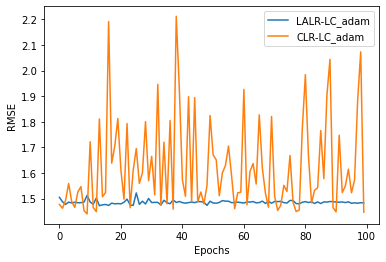

In [49]:
# plt.plot(range(100), valList_LBFGS_LC, label="Log-Cosh-LBFGS")
# plt.plot(range(100), valList_LBFGS_MSE, label="MSE-LBFGS")
# plt.plot(range(100), valList_CLR_MSE, label="CLR-MSE_adam")
# plt.plot(range(100), valList_LALR_MSE, label="LALR-MSE_adam")
# plt.plot(range(100), valList_CLR_L1, label="CLR-L1_adam")
# plt.plot(range(100), valList_LALR_L1, label="LALR-L1_adam")
# plt.plot(range(100), valList_LALR_LC, label="LALR-LC_adam")
# plt.plot(range(100), valList_CLR_LC, label="CLR-LC_adam")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()